In [1]:
# import some packages
import numpy as np
import welly

In [2]:
import os
env = %env

In [3]:
from welly import Well

In [4]:
import pandas as pd

In [5]:
picks_dicts = pd.read_table("data/SPE_006/OilSandsDB/PICKS_DIC.TXT", delimiter='\t')

C:\Users\gushi\Anaconda3\envs\env_full\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


In [6]:
picks_dicts

,HorID,Descriptopn
0,1000,mannville
1,2000,t61
2,3000,t51
3,4000,t41
4,5000,t31
5,6000,clw_wab
6,7000,t21
7,8000,e20
8,9000,t15
9,9500,e14


In [7]:
picks = pd.read_table("data/SPE_006/OilSandsDB/PICKS.TXT", delimiter='\t')
mcmurray_top = picks[picks['HorID'] == 13000]
mcmurray_top.head()

C:\Users\gushi\Anaconda3\envs\env_full\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


,SitID,HorID,Pick,Quality
12,102496,13000,475,3
26,102497,13000,515,3
40,102498,13000,480,3
54,102500,13000,549,3
68,102501,13000,529,2


In [8]:
wells = pd.read_table("data/SPE_006/OilSandsDB/WELLS.TXT", delimiter= '\t')

wells.head()

C:\Users\gushi\Anaconda3\envs\env_full\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: read_table is deprecated, use read_csv instead.
  """Entry point for launching an IPython kernel.


,SitID,UWI (AGS),UWI
0,102496,0674010812000,00/12-08-067-01W4/0
1,102497,0674020807000,00/07-08-067-02W4/0
2,102498,0674021109000,00/09-11-067-02W4/0
3,102500,0674022910000,00/10-29-067-02W4/0
4,102501,0674023406000,00/06-34-067-02W4/0


In [9]:
import numpy as np

well_locs = pd.read_csv('data/MannvilleWells_LatLong_notab.csv')
well_locs.head()

well_locs.dropna(inplace=True, subset=['Pick'])

well_locs['Pick'] = well_locs['Pick'].astype(float)

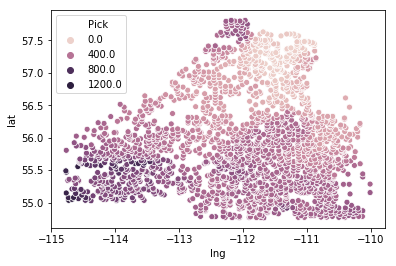

In [10]:
import matplotlib.cm as cm

import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline

ax = sns.scatterplot(x="lng", y="lat", hue="Pick", data=well_locs)



In [11]:
import sklearn
from sklearn.model_selection import train_test_split

In [12]:
X = well_locs[['lat', 'lng']]
y = well_locs['Pick']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
y_train.head()

2178    513.28
1453    449.28
976     535.84
2095     22.50
864     630.33
Name: Pick, dtype: float64

In [13]:
from sklearn import gaussian_process

#https://stackoverflow.com/questions/45175201/how-can-i-interpolate-station-data-with-kriging-in-python
kern = gaussian_process.kernels.RBF(length_scale_bounds=(1e-3,1e-1))
gp = gaussian_process.GaussianProcessRegressor(normalize_y=True, n_restarts_optimizer=10, kernel=kern)
gp.fit(X_train, y_train)



GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=1), n_restarts_optimizer=10,
             normalize_y=True, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [14]:
import numpy as np
y_samp = gp.sample_y(np.array([-110.2034006,57.807827 ]).reshape(1, -1))
y_samp
X_train.head()

,lat,lng
2178,57.727826,-112.019989
1453,56.211752,-111.174674
976,55.717502,-114.043810
2095,57.419037,-110.883548
864,55.597151,-113.301750


In [15]:
from sklearn import metrics


y_pred = gp.predict(X_test)


metrics.mean_squared_error(y_test, y_pred)

2486.5610648834545

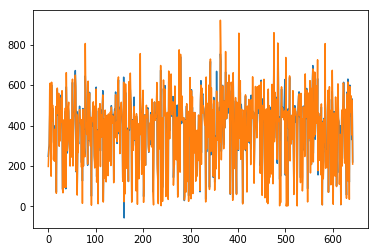

In [16]:
plt.plot(y_pred)
plt.plot(y_test.values)

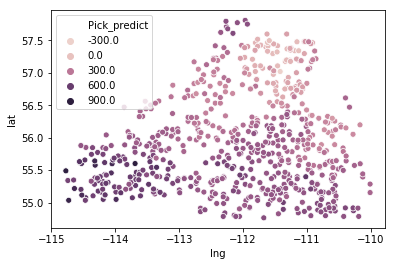

In [17]:
predict_map = X_test.copy()
y_pred.shape
predict_map['Pick_predict'] = y_pred.reshape(-1,1)
ax = sns.scatterplot(x="lng", y="lat", hue="Pick_predict", data=predict_map)

(-114.774119, -110.008902)
[[  54.764109   -114.774119  ]
 [  54.82622569 -114.774119  ]
 [  54.88834239 -114.774119  ]
 ...
 [  57.68359361 -110.008902  ]
 [  57.74571031 -110.008902  ]
 [  57.807827   -110.008902  ]]


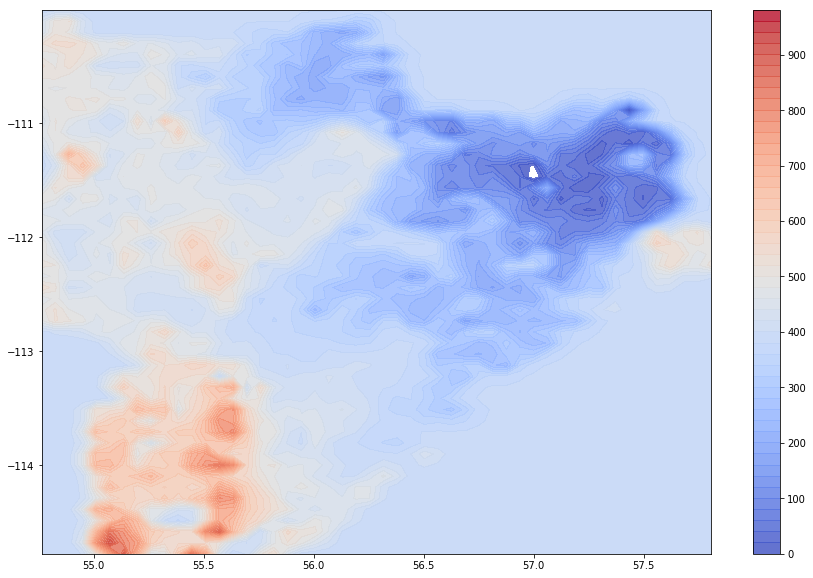

In [18]:
xmin, xmax = well_locs['lat'].min(), well_locs['lat'].max()
ymin, ymax = well_locs['lng'].min(), well_locs['lng'].max()

print((ymin,ymax))

xspace, yspace = np.linspace(xmin, xmax), np.linspace(ymin, ymax)
xx, yy = np.meshgrid(xspace, yspace)


Z = gp.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)

print(np.c_[xx.ravel(), yy.ravel()])

fig, ax = plt.subplots(figsize=(15,10))

contour_plot = ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8, levels=range(0,1000,20))
fig.colorbar(contour_plot)

In [19]:
#import skgstat as skg

#V = skg.DirectionalVariogram(coordinates=np.array(X_train[['lat','lng']]), 
#                             values=y_train, azimuth=0, tolerance=30,directional_model='triangle',
#                            fit_method='lm', bandwidth=0.2, maxlag=0.8, n_lags=8)
#plots = V.plot()

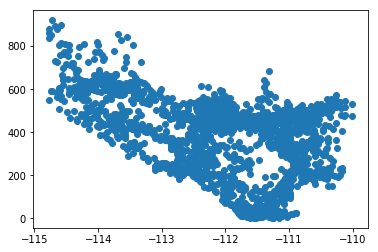

In [42]:
plt.scatter(well_locs['lng'], well_locs['Pick'])

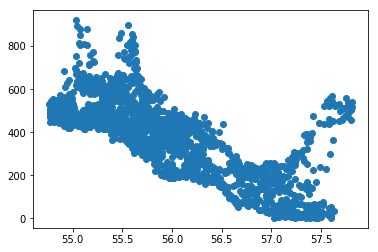

In [43]:
plt.scatter(well_locs['lng'], well_locs['Pick'])

In [38]:
from pykrige.ok import OrdinaryKriging

OK = OrdinaryKriging(well_locs['lng'], well_locs['lat'],
                    well_locs['Pick'], variogram_model='spherical')

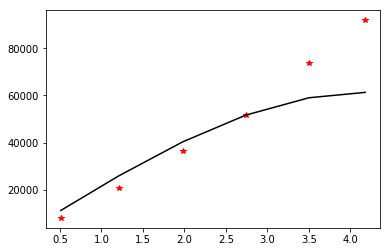

In [39]:
OK.display_variogram_model()

In [ ]:
import sys

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from pykrige.rk import RegressionKriging
from pykrige.compat import train_test_split

svr_model = SVR(C=0.1)
rf_model = RandomForestRegressor(n_estimators=100)
lr_model = LinearRegression(normalize=True, copy_X=True, fit_intercept=False)

models = [svr_model, rf_model, lr_model]


# take the first 5000 as Kriging is memory intensive
p = housing['data'][:5000, :-2]
p = well_locs[['lat', 'lng']]
target = well_locs['Pick']

p_train, p_test, x_train, x_test, target_train, target_test \
    = train_test_split(p, x, target, test_size=0.3, random_state=42)

for m in models:
    print('=' * 40)
    print('regression model:', m.__class__.__name__)
    m_rk = RegressionKriging(regression_model=m, n_closest_points=10)
    m_rk.fit(p_train, x_train, target_train)
    print('Regression Score: ', m_rk.regression_model.score(p_test, target_test))
    print('RK score: ', m_rk.score(p_test, x_test, target_test))

In [44]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

In [48]:
housing['data'][0:1,-2:]


#Ultimately I want to do regression kriging on this dataset
#Will need to extract features from the time series that can be used
#    in this context 


array([[  37.88, -122.23]])

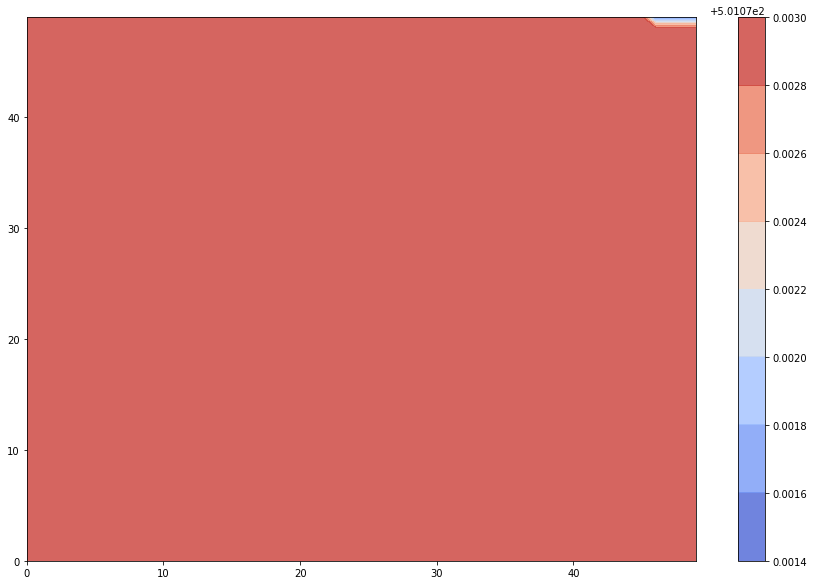

In [40]:
z, ss = OK.execute('grid', xspace, yspace)

fig, ax = plt.subplots(figsize=(15,10))
import sys

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
contour_plot = ax.contourf(z, cmap=plt.cm.coolwarm, alpha=0.8)
fig.colorbar(contour_plot)

Now_optimizing_for_q = 1 

Now_optimizing_for_q = 2 

Now_optimizing_for_q = 5 

Now_optimizing_for_q = 10 

Now_optimizing_for_q = 20 

Now_optimizing_for_q = 50 

Now_optimizing_for_q = 100 

Best_lh_found_using_q = 2 

Infill iteration 1 of 5....
Infill iteration 2 of 5....
Infill iteration 3 of 5....
Infill iteration 4 of 5....
Infill iteration 5 of 5....


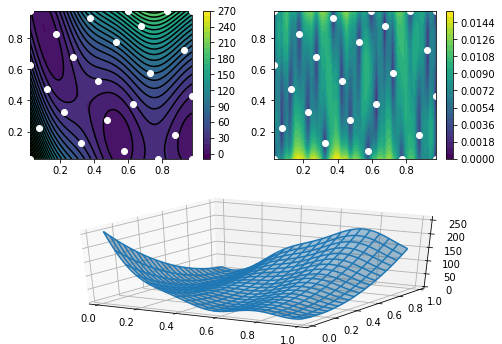

In [21]:
import pyKriging  
from pyKriging.krige import kriging  
from pyKriging.samplingplan import samplingplan

# The Kriging model starts by defining a sampling plan, we use an optimal Latin Hypercube here
sp = samplingplan(2)  
X = sp.optimallhc(20)

# Next, we define the problem we would like to solve
testfun = pyKriging.testfunctions().branin  
y = testfun(X)

# Now that we have our initial data, we can create an instance of a Kriging model
k = kriging(X, y, testfunction=testfun, name='simple')  
k.train()

# Now, five infill points are added. Note that the model is re-trained after each point is added
numiter = 5  
for i in range(numiter):  
    print('Infill iteration {0} of {1}....'.format(i + 1, numiter))
    newpoints = k.infill(1)
    for point in newpoints:
        k.addPoint(point, testfun(point)[0])
    k.train()

# And plot the results
k.plot()  